# kNN Model

## Import Statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import copy

## Hyperparameters

In [22]:
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
num_splits = 10
k = 1               # for k-NN
num_subsets = 10
num_features = 17

## Read in Data

In [23]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
# dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set_hourly = "hourly_data_2017"
data_set = "all_data_summer"

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")
X = X.astype(float)
y = y.astype(int)

num_features = X.shape[1]

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: 0 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# undersample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx >= (len(y) - 1):
        idx = 0

    if y[idx] == 0:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.delete(y, idx)
            X = np.delete(X, obj=idx, axis=0)
            num_no_alg -= 1
        else:
            idx += 1
    else:
        idx += 1

In [24]:
# Shuffle the data
shuff_idx = np.arange(X.shape[0])
np.random.shuffle(shuff_idx)

X = X[shuff_idx, :]
y = y[shuff_idx]

## Define Model

In [25]:
knn = KNeighborsClassifier(
    n_neighbors=k,
    weights="uniform",
    algorithm="brute",
    p=2,
    metric="minkowski",
    n_jobs=None
)

## Run Model

In [26]:
# Perform 10-fold CV on all models
skf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=False)

acc = [0] * num_subsets

fold = 1
print("Fold #: ", end=" ")

for train_idx, test_idx in skf.split(X, y):
    print(str(fold), end=" ")
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
        
    X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
    X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)
    
    for i in range(num_subsets):
        sub_idx = int(np.floor(((i+1) * X_train.shape[0])) / float(num_subsets))
        X_train_sub = X_train[:sub_idx, :]        
        y_train_sub = y_train[:sub_idx]
        
        # knn
        knn.fit(X_train_sub, y_train_sub)
        knn_pred = knn.predict(X_test)
        knn_prob = knn.predict_proba(X_test)[:, 1]

        # accuracy calculation
        acc[i] += (np.sum(knn_pred == y_test) / len(y_test))
    
    fold += 1

acc[:] = [float(i) / float(num_splits) for i in acc]

Fold #:  1 2 3 4 5 6 7 8 9 10 

## Plot Results

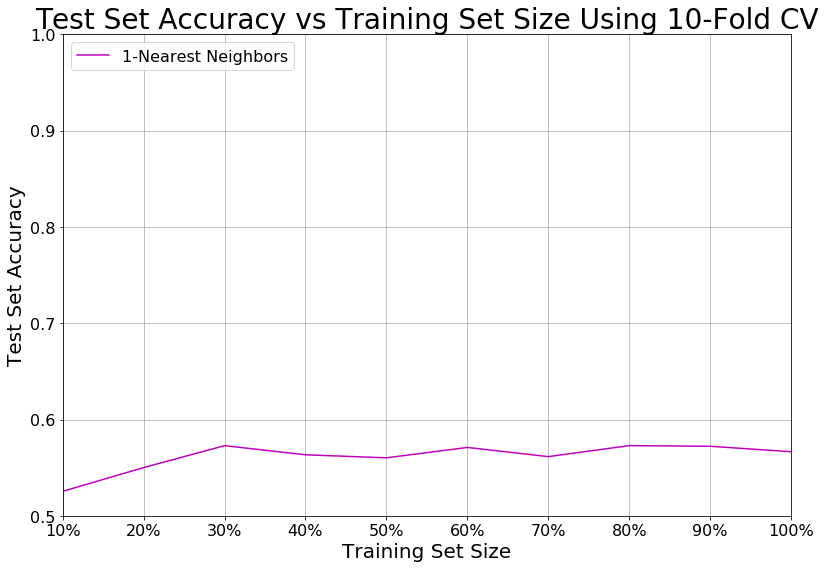

In [27]:
folds = [i+1 for i in range(num_splits)]

plt.figure(figsize=(12, 8))
plt.plot(folds, acc, color="m", label=str(k) + "-Nearest Neighbors")
plt.xlabel("Training Set Size", fontsize=20)
plt.xticks(np.arange(num_subsets)+1, ("10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Test Set Accuracy", fontsize=20)
plt.title("Test Set Accuracy vs Training Set Size Using 10-Fold CV", fontsize=28)
plt.axis([1, num_splits, 0.5, 1])
plt.legend(loc="upper left", prop={"size": 16})
plt.tight_layout()
plt.grid(True)

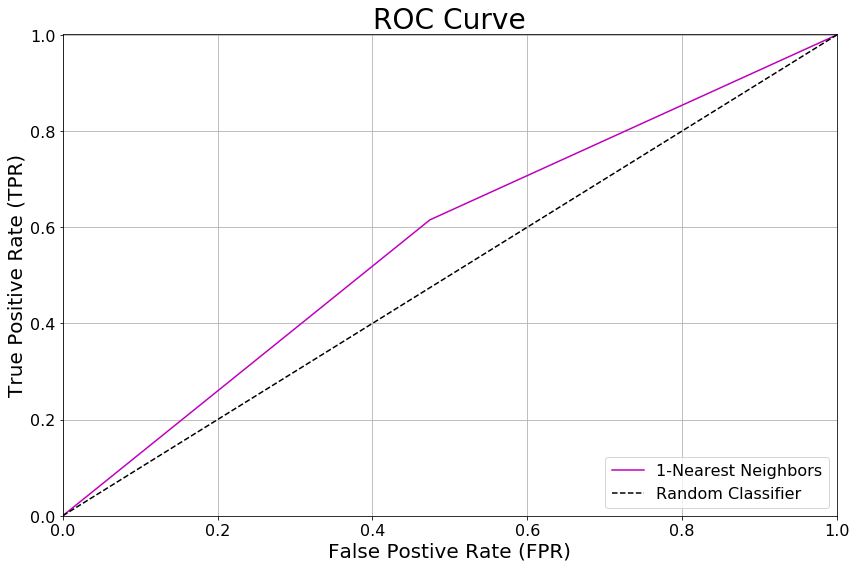

In [28]:
fpr, tpr, _ = roc_curve(y_test, knn_prob, pos_label=1)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(0.1*np.arange(12), 0.1*np.arange(12), color="k", linestyle="dashed", label="Random Classifier")
plt.xlabel("False Postive Rate (FPR)", fontsize=20)
plt.ylabel("True Positive Rate (TPR)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title("ROC Curve", fontsize=28)
plt.legend(loc="lower right", prop={"size": 16})
plt.tight_layout()
plt.grid(True)